Quatum Trajectories Rc mapping

$  H_0= \frac{\omega}{2} \sigma_z + \frac{\Delta}{2} \sigma_x+ \Omega b ^{\dagger} b +g \sigma_z  \left( b + b ^{\dagger} \right) + \frac{g^2}{\Omega} \sigma_z^2 + \Omega \Delta_{RC} \left( b + b ^{\dagger} \right)^2$

$   H_B= \sum_{k} \Omega_k b_k ^{\dagger} b_k $

$   H_I= \left( b + b ^{\dagger} \right) \sum_k h_k \left( b_k + b_k ^{\dagger} \right)$


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from numpy import linalg as LA
import scipy.integrate as integrate
from scipy.integrate import quad

We construct the algebra of the $2 \otimes n$ Hilbert space for the supersystem (2 level system and RC)

In [2]:
#### Parameters 

###################################
delta = 1.0    # The number of qubits in the system.
omega = 0.5     # Energy of the 2-level system.
Hsys = 0.5 * omega * sigmaz() + 0.5 * delta * sigmax()



wc = 0.05                # Cutoff frequency.
alpha = 2.5/np.pi        # Coupling strength.
N = 10                   # Number of cavity fock states.
Temperature = 1/0.95     # Tempertaure.


dot_energy, dot_state = Hsys.eigenstates()
deltaE = dot_energy[1] - dot_energy[0]
if (Temperature < deltaE/2):
    warnings.warn("Given w_th might not provide accurate results")
gamma = deltaE / (2 * np.pi * wc)
wa = 2 * np.pi * gamma * wc  # reaction coordinate frequency
g = np.sqrt(np.pi * wa * alpha / 2.0)  # reaction coordinate coupling
nb = (1 / (np.exp(wa/Temperature) - 1))


print(gamma)
print(wa)



## Rc parameters
omega_Rc= wa #10.0
delta_Rc= (2/(375*np.pi))/omega_Rc
#g=0.1795755
##Temeperature
beta=0.95

##################### Hilbert space for the Hamitonial 
N_RC = 10 # number of basis states to consider
b = destroy(N_RC)

H0= omega/2 *tensor(sigmaz(), identity(N_RC) ) +  delta/2 *tensor(sigmax(), identity(N_RC) ) + omega_Rc *tensor(identity(2) , b.dag() * b )  + g* tensor(sigmaz(),  b.dag() + b ) + omega_Rc*delta_Rc *tensor(identity(2) , (b.dag() + b)*(b.dag() + b) ) 





#print(H0)


3.5588127170858854
1.118033988749895


We want ot star with a pure state of the type: 
<img src="initial_state_RC.PNG">

In orther to evolve this steta we need the pure state depocosition of the desity matrix

In [3]:
# initial state
#we defina a canoncical state 

##psi0 = basis(N_RC, 1)  ##A pure state to test  


##Rc inicial state Thermal  
H1 = b.dag() * b
H2 = delta_Rc*(b.dag()+ b)*(b.dag()+ b)
H_Rc= -beta*omega_Rc*(H1+H2)
Exp= H_Rc.expm()
Z_Rc=Exp.tr()
rho_Rc_init=Exp/Z_Rc

#print(rho_Rc_init)

#psi0 = (1/np.sqrt(2.)) * (basis(2, 0) + basis(2, 1) )
psi0 =  basis(2, 0) 

##Spin Inicial state 
rho_Spin= psi0*psi0.dag()
#print(rho_Spin)

###Tensor producto of the initial state
rho_init=tensor(rho_Spin,rho_Rc_init) 
#print(rho_init)
#print(rho_init.ptrace(0))
#rho_init_IP=(1j*H0).expm()* rho_init*  (-1j*H0).expm()
#print(rho_init_IP)
#EV=rho_init.eigenstates()
#print(EV)
###Pure state Decomposition 

We prefomr the QT on the this system with a Limbland equation for the supersystem: 

<img src="Limband_eq.PNG">

where $\gamma'=J(\Omega)\left[1+n_{B}(\Omega)\right]$ , $ \bar{\gamma}' = J(\Omega) n_{B}(\Omega)$ and $n_{B}(\omega)=\left[e^{\beta \omega}-1\right]^{-1}$

In [4]:
Gamma=gamma*omega_Rc*(1+nb)
Gamma_bar=gamma*omega_Rc*nb

print(Gamma)
print(Gamma_bar)



#gamma= 6.081280985140722#3.78385
#gamma_bar=2.102407407843339 # 3.19535
L1=tensor(identity(2) ,  b )
L2=tensor(identity(2) , b.dag()  )
L=[np.sqrt(Gamma) * L1, np.sqrt(Gamma_bar)*L2 ]
N=len(L)

#print(L)

6.081280985140722
2.102407407843339


In [5]:
t0 = 0.0
tf = 40.0
time_steps = 200



## Time range
t = np.linspace(0, tf, time_steps)

result = mesolve(H0, rho_init, t, L, options=Options(nsteps=1000))
plt.rcParams['figure.figsize'] = [15,5]

states_IP=result.states
exp_result=[0 for i in range(len(states_IP))]
trace=[0 for i in range(len(states_IP))]
for i in range(len(states_IP)):
    exp_result[i]=  (-1j*H0*t[i]).expm()* states_IP[i]*  (1j*H0*t[i]).expm()
    trace[i]=  exp_result[i].ptrace(0)

#print(states_IP[0])
#plt.plot(t,result.expect[0],label='rx ME', color = "g")
#plt.plot(t,result.expect[1],label='ry ME', color = "b")
#plt.plot(t,result.expect[2],label='rz ME', color = "r")
#plt.xlabel('time')
#plt.legend()
#plt.show()

In [6]:
print(trace[0])

p00=[0 for i in range(len(states_IP))]
for i in range(len(states_IP)):
    p00[i]=abs(0.5*expect(sigmaz()+identity(2),trace[i]))
    
###Exact sol




Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]


In [7]:
from qutip.nonmarkov.heom import HSolverDL
# Defining the system Hamiltonian
eps = 0.5     # Energy of the 2-level system.
Del = 1.0    # Tunnelling term
Hsys = 0.5*eps*sigmaz() + 0.5*Del* sigmax()


temperature = 1.0/0.95 # in units where Boltzmann factor is 1
Nk = 4 # number of exponentials in approximation of the the spectral density
Ncut = 30 # cut off parameter for the bath

temperature = 1.0/0.95 # in units where Boltzmann factor is 1
Nk = 2 # number of exponentials in approximation of the the spectral density
Ncut = 30 # cut off parameter for the bath

Q = sigmaz() # coupling operator
gam = 0.05 # cut off frequency
lam =  2.5/np.pi # coupling strenght

In [8]:
hsolver = HSolverDL(Hsys, Q, lam, temperature, Ncut, Nk, gam, stats=True)

In [9]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
tlist = np.linspace(0, 40, 600)
# run the solver
result = hsolver.run(rho0, tlist)
hsolver.stats.report()



Hierarchy Solver Stats

config
------
### Timings:
 - 0:00:00.325997 (97.53% section, 18.96% total)	hierarchy contruct
 - 0:00:00.000889 (0.27% section, 0.05% total)	Liouvillian contruct
 - 0:00:00.334265	config total time
### Counts:
 - 496	Num hierarchy elements
 - 1860	Num he interactions
### Messages:
 - options:	renormalisation;boundary cutoff approx

run
---
### Timings:
 - 0:00:00.000653 (0.05% section, 0.04% total)	initialize
 - 0:00:01.384821 (99.95% section, 80.52% total)	integrate
 - 0:00:01.385492	run total time
### Counts:
### Messages:

Summary
-------
0:00:01.719757	 solver total time


In [10]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
#P11p=basis(2,0) * basis(2,0).dag()
P00p=0.5*(sigmaz()+identity(2))
# 1,2 element of density matrix  - corresonding to coherence
P01p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P00exp = expect(result.states, P00p)
P01exp = expect(result.states, P01p)


#result = sesolve(Hsys, basis(2,0), tlist, [P11p])


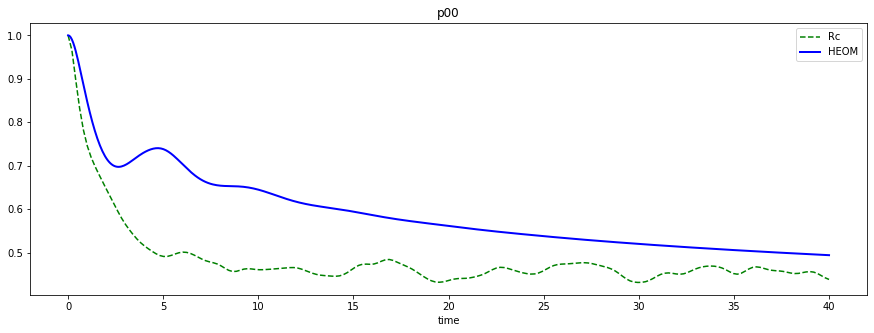

In [11]:
plt.title("p00")
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(t,p00,"--",label='Rc', color = "g")
plt.plot(tlist, np.real(P00exp), 'b', linewidth=2, label="HEOM")

#plt.plot(tlist, result.expect[0])
plt.xlabel("time")
plt.legend()
plt.show()